In [1]:
%reset

from blocks.serialization import load
with open('ali_conditional_celeba.tar', 'rb') as src:
    main_loop = load(src)
ali, = main_loop.model.top_bricks
import theano.tensor as tensor
x = tensor.tensor4('features')
y = tensor.matrix('y')


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 5.0% of memory, cuDNN 5105)


/home/hope-yao/anaconda2/lib/python2.7/site-packages/blocks/bricks/conv.py:344: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  ignore_border=self.ignore_border)


y: [1 1]


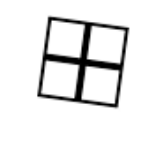

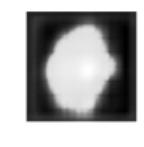

y_hat: [ 0.99006325  1.        ]
y: [1 1]


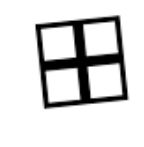

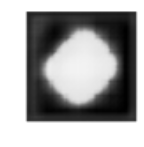

y_hat: [ 0.99114543  1.        ]
y: [0 0]


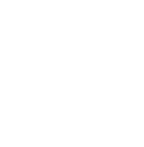

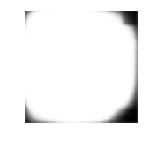

y_hat: [  8.17549806e-10   5.82751170e-07]
y: [0 0]


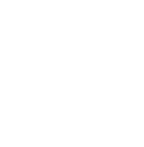

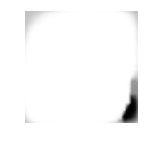

y_hat: [  4.04513534e-10   1.05924551e-06]
y: [0 1]


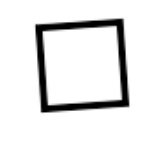

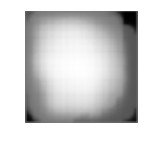

y_hat: [  1.44957767e-05   1.00000000e+00]
y: [1 1]


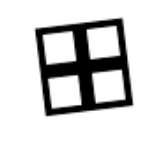

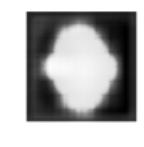

y_hat: [ 0.98708457  1.        ]
y: [0 0]


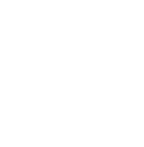

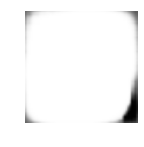

y_hat: [  1.18677446e-09   2.67827033e-07]
y: [1 1]


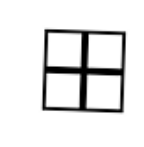

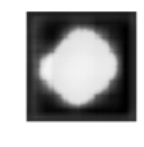

y_hat: [ 0.9889214  1.       ]
y: [0 1]


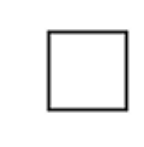

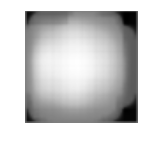

y_hat: [  6.25925371e-04   1.00000000e+00]
y: [1 1]


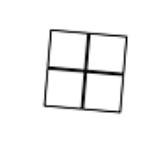

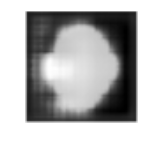

y_hat: [ 0.9794814  1.       ]
y: [0 1]


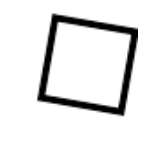

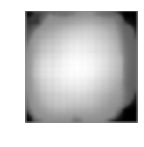

y_hat: [ 0.02332899  1.        ]
y: [0 0]


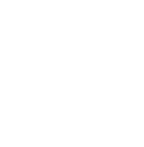

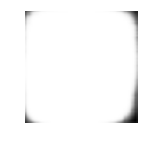

y_hat: [  2.05222128e-09   1.44009903e-07]
y: [0 1]


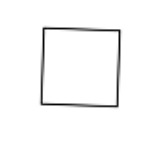

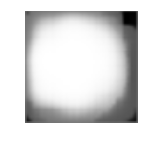

y_hat: [  1.27501973e-08   9.99971032e-01]
y: [1 1]


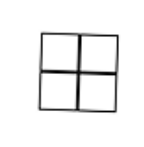

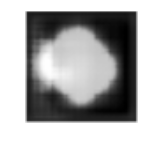

y_hat: [ 0.98919362  1.        ]
y: [0 0]


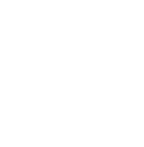

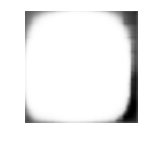

y_hat: [  2.79800461e-10   3.08791277e-06]
y: [1 1]


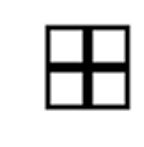

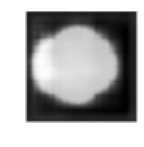

y_hat: [ 0.98884845  1.        ]


In [2]:
# reconstruction

num_examples = 400
from ali import streams
_1, _2, data_stream = streams.create_crs_data_streams(num_examples,
                                                           num_examples,
                                                           sources=('features', 'targets'),
                                                           )
x, y = next(data_stream.get_epoch_iterator())

embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings).eval()  # G_z(x,e(y))
y0, y1 = embeddings[:,0:1,:,:], embeddings[:,1:,:,:]
x_hat = ali.decoder.apply(z_hat, [y0, y1]).eval()  # G_x(z,e(y))
y_hat = ali.classifier.apply(x_hat).eval()

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x[idx]))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print('y_hat: {}'.format(y_hat[idx]))

x_hat0 = x_hat[0]

In [3]:
data_preds, sample_preds = ali.get_predictions(x_hat, z_hat,x, z_hat,embeddings)

In [4]:
sum(i < 0 for i in data_preds.eval()),sum(i < 0 for i in sample_preds.eval())

(array([[[71]]]), array([[[122]]]))

### Add new data

In [5]:
np.save('x_hat',x_hat)

In [6]:
# % reset
from fuel.datasets.hdf5 import H5PYDataset
import numpy as np
mnist_test = H5PYDataset('/home/hope-yao/Documents/Data/rect_rectcrs20.hdf5', which_sets=('train','valid',))
handletest = mnist_test.open()
x,y = mnist_test.get_data(handletest, slice(0, mnist_test.num_examples))
np.asarray(x).shape
x_hat = np.load('x_hat.npy')
y_hat = np.zeros((x_hat.shape[0],2))
data = np.concatenate([x,x_hat],axis=0)
label = np.concatenate([y,y_hat],axis=0)

In [7]:
label.shape

(2930, 2)

In [8]:
from random import sample

split = 0.2
l = len(data) #length of data
n1 = int(split*l)  # split for testing
n2 = l - n1
indices = sample(range(l),n1)

data_test = data[indices]
label_test = label[indices]

data_train = np.delete(data,indices,0)
label_train = np.delete(label,indices,0)

# %reset
import h5py

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('rectcrs.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 2
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

### reconstruction of celebA

In [ ]:
# reconstruction

num_examples = 100
from ali import streams
_1, _2, data_stream = streams.create_celeba_data_streams(num_examples,
                                                           num_examples,
                                                           sources=('features', 'targets'),
                                                           )
x, y = next(data_stream.get_epoch_iterator())

In [ ]:
from numpy.random import rand
embeddings = ali.embedder.apply(y).eval()
embeddings[0:1,0+10:20+10,0:1,0:1] = rand(1,20,1,1)
# embeddings[0] = np.zeros((1,256,1,1))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x_hat[0],[1,2,0])))
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x_hat[0],[1,2,0])))
plt.axis('off')
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x[2],[1,2,0])))
plt.axis('off')
plt.show()


embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings)  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
#     plt.imshow(np.squeeze(x[idx]))
    plt.imshow(np.squeeze(np.transpose(x[idx],[1,2,0])))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
#     plt.imshow(np.squeeze(x_hat[idx]))
    plt.imshow(np.squeeze(np.transpose(x_hat[idx],[1,2,0])))
    plt.axis('off')
    plt.show()


### CRS DATA

### CRS Subtraction

In [ ]:
z_sub = z_hat-z_hat[4]
yy = np.ones_like(y)
yy[:,1]=0
e_sub = ali.embedder.apply(yy)
x_hat = ali.decoder.apply(z_sub, e_sub).eval()  # G_x(z,e(y))

for idx in range(16):
    print(idx)
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])

z_sub0 = z_sub[0]
e_sub0 = e_sub[0]
x_sub0 = x_hat[0]



In [ ]:
z_sub = z_hat-z_hat[4]
e_sub = embeddings-embeddings[4]
x_hat = ali.decoder.apply(z_sub, e_sub).eval()  # G_x(z,e(y))


for idx in range(16):
    print(idx)
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])

z_sub1 = z_sub[0]
e_sub1 = e_sub[0]
x_sub1 = x_hat[0]


### reconstruct unseen data

In [ ]:
from theano import tensor
BATCH_SIZE = 128
RATIO = 16
NLAT = 256/RATIO

y_b = tensor.stack( [tensor.ones((BATCH_SIZE,)), tensor.zeros((BATCH_SIZE,))], axis=1 )# (1,0)
embeddings = ali.embedder.apply(y_b)
z_b_hat = ali.theano_rng.normal(size=(BATCH_SIZE, NLAT, 1, 1))
x_b = ali.decoder.apply(z_b_hat ,embeddings)
y_b_hat = ali.classifier.apply(x_b)
y_b_hat = y_b_hat.reshape((BATCH_SIZE,2))
y_b_0 = tensor.stack( [tensor.zeros((BATCH_SIZE,)), tensor.zeros((BATCH_SIZE,))], axis=1 )# (0,0)
y_b_1 = tensor.stack( [tensor.ones((BATCH_SIZE,)), tensor.zeros((BATCH_SIZE,))], axis=1 )# (1,0)
y_b_2 = tensor.stack( [tensor.ones((BATCH_SIZE,)), tensor.ones((BATCH_SIZE,))], axis=1 )# (1,1)
# basis_cost  = - ( tensor.sum(y_b_0*tensor.log(y_b_hat+eps)) + tensor.sum((1-y_b_0)*tensor.log(1-y_b_hat+eps)) )
# basis_cost += - ( tensor.sum(y_b_1*tensor.log(y_b_hat+eps)) + tensor.sum((1-y_b_1)*tensor.log(1-y_b_hat+eps)) )
# basis_cost += - ( tensor.sum(y_b_2*tensor.log(y_b_hat+eps)) + tensor.sum((1-y_b_2)*tensor.log(1-y_b_hat+eps)) )
# basis_cost = tensor.sum ( 1./(10.- tensor.sum(tensor.sqr(y_b_hat-y_b_0),1)) + 1./(10.- tensor.sum(tensor.sqr(y_b_hat-y_b_1),1)) + 1./(10.- tensor.sum(tensor.sqr(y_b_hat-y_b_2),1)) )
basis_cost = -tensor.log(tensor.mean( tensor.sum(tensor.sqr(y_b_hat-y_b_0),1) + tensor.sum(tensor.sqr(y_b_hat-y_b_1),1) + tensor.sum(tensor.sqr(y_b_hat-y_b_2),1) ))
basis_cost.name = 'basis_cost'  # Basis cost is negative of cross entropy, but to be maximized

In [ ]:
y_b_hat.eval()

In [ ]:
xx_b = x_b.eval()
for idx in range(16):
    print(idx)
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(xx_b[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])

In [ ]:
import numpy as np

nn = np.load('/home/hope-yao/Documents/Data/rec_crs.npy')
dim = 64
crs = nn.item()['cross_img']#['cross_img']
crs = crs.reshape(crs.shape[0],1,dim,dim)
xx = crs[0:100]
yy = np.asarray([[1,0]]*100)
xx = xx.astype('float32')
yy = yy.astype('uint8')


In [ ]:

import numpy as np
from random import sample

x = xx
y = yy

embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings).eval()  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
y_hat = ali.classifier.apply(x_hat).eval()

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x[idx]))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print('y_hat: {}'.format(y_hat[idx]))

# x_hat0 = x_hat[0]

### Add manually labeled data

In [ ]:
# %reset
import numpy as np
from random import sample

nn = np.load('/home/hope-yao/Documents/Data/rec_crs.npy')
dim = 64

crs = nn.item()['rectcrs_img']#['cross_img']
crs = crs.reshape(crs.shape[0],1,dim,dim)
# crs_label = [[1,0]+[0]*0] * crs.shape[0]
crs_label = [[1,1]+[0]*0] * crs.shape[0]

rec = nn.item()['rect_img']
rec = rec.reshape(rec.shape[0],1,dim,dim)
rec_label = [[0,1]+[0]*0] * rec.shape[0]

datas = np.append(crs,rec,0)
labels = np.append(crs_label,rec_label,0)

ttn = 128*4
data = [datas[len(datas)/ttn*i] for i in range(ttn) ]
label = [labels[len(datas)/ttn*i] for i in range(ttn) ]
data = np.append(data,x_hat,0)
label = np.append(label,[[0,0]]*len(x_hat),0)
data = np.asarray(data)
label = np.asarray(label)

split = 0.2
l = len(data) #length of data
n1 = int(split*l)  # split for testing
n2 = l - n1
indices = sample(range(l),n1)

data_test = data[indices]
label_test = label[indices]

data_train = np.delete(data,indices,0)
label_train = np.delete(label,indices,0)

In [ ]:
x_hat.shape

In [ ]:
# %reset
import h5py

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('rectcrs.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 2
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

## MNIST DATASET

In [ ]:
% reset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
(mnist.train.images).shape, (mnist.train.labels).shape

In [ ]:
# %reset
import numpy as np
import h5py
data_train = mnist.train.images
label_train = mnist.train.labels
data_test = mnist.test.images
label_test = mnist.test.labels

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(1,28,28))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(1,28,28))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('Mnist28.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 10
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

## MNIST64 DATASET

In [ ]:
import numpy as np
labels = mnist.train.labels
idx1 = idx2 = idx3 = idx4 = idx5 = idx6 = idx7 = idx8 = []
for i in range(mnist.train.labels.shape[0]):
    tmp = np.argmax(mnist.train.labels[i,:])
    if tmp == 1:
        idx1 = idx1 + [i]
    if tmp == 2:
        idx2 = idx2 + [i]
    if tmp == 3:
        idx3 = idx3 + [i]
    if tmp == 4:
        idx4 = idx4 + [i]
    if tmp == 5:
        idx5 = idx5 + [i]
    if tmp == 6:
        idx6 = idx6 + [i]
    if tmp == 7:
        idx7 = idx7 + [i]
    if tmp == 8:
        idx8 = idx8 + [i]        
        

In [ ]:
images = mnist.train.images
data = []
label = []
pad = 2
nbatch = 400

for j in range(128*nbatch):
    print(j)
    imgs = np.zeros((64,64))
    labeli = []
    for i in range(4):
        kk = np.int(np.random.rand(1)[0]+0.5)
        # upperleft, lowerleft, upperright, lowerright
        if i==0:
            if not kk:
                img = images[np.random.choice(idx1)].reshape(28,28)
            else:
                img = images[np.random.choice(idx2)].reshape(28,28)
            imgs[0+pad:28+pad,0+pad:28+pad] = img
        if i==1:
            if not kk:
                img = images[np.random.choice(idx3)].reshape(28,28)
            else:
                img = images[np.random.choice(idx4)].reshape(28,28)
            imgs[28+pad+2*pad:2*28+pad+2*pad,0+pad:28+pad] = img
        if i==2:
            if not kk:
                img = images[np.random.choice(idx5)].reshape(28,28)
            else:
                img = images[np.random.choice(idx6)].reshape(28,28)
            imgs[0+pad+2*pad:28+pad+2*pad,28+pad:2*28+pad] = img
        if i==3:
            if not kk:
                img = images[np.random.choice(idx7)].reshape(28,28)
            else:
                img = images[np.random.choice(idx8)].reshape(28,28)
            imgs[28+pad+2*pad:2*28+pad+2*pad,28+pad+2*pad:2*28+pad+2*pad] = img
        labeli = labeli +[kk] 
    label = label + [labeli] 
    data = data + [imgs]
data = np.asarray(data)
label = np.asarray(label)

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
idx = 10
plt.imshow(np.squeeze(data[idx]))
print(label[idx])
plt.show()

In [ ]:
import numpy as np
from random import sample

split = 0.2
l = len(data) #length of data
n1 = int(split*l)  # split for testing
n2 = l - n1
indices = sample(range(l),n1)

data = data.reshape(data.shape[0],1,data.shape[1],data.shape[2])
data_test = data[indices]
label_test = label[indices]

data_train = np.delete(data,indices,0)
label_train = np.delete(label,indices,0)

In [ ]:
# %reset
import h5py

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('Mnist64.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 4
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

In [ ]:
from theano import tensor
from blocks.bricks import LeakyRectifier, Logistic, Rectifier, Softmax, Activation
from ali.conditional_bricks import (EncoderMapping, Decoder,
                                    GaussianConditional, XZYJointDiscriminator,
                                    ConditionalALI, LeNet)
from blocks.initialization import IsotropicGaussian, Constant, Uniform

NCLASSES = 4
feature_maps = [16, 32, 64]
mlp_hiddens = [100]
output_size = NCLASSES
image_size = (64, 64)

conv_activations = [Rectifier() for _ in feature_maps]
mlp_activations = [Rectifier() for _ in mlp_hiddens] + [Logistic()]
convnet = LeNet(conv_activations, 1, image_size,
                filter_sizes=[(3, 3), (3, 3), (3, 3)],
                feature_maps=feature_maps,
                pooling_sizes=[(2, 2), (2, 2), (2, 2)],
                top_mlp_activations=mlp_activations,
                top_mlp_dims=mlp_hiddens + [output_size],
                border_mode='valid',
                weights_init=Uniform(width=.5),
                biases_init=Constant(0)
                )

convnet.push_initialization_config()
convnet.initialize()

classifier = convnet
x = tensor.tensor4('features')
y = tensor.matrix('targets')
BATCH_SIZE = 128
pred = classifier.apply(x)
EPS = 1e-8
classifier_cost = - ( tensor.sum(y*tensor.log(pred+EPS)) + tensor.sum((1-y)*tensor.log(1-pred+EPS)) )
# classifier_error = tensor.sum(tensor.sqr(y - pred))/BATCH_SIZE/NCLASSES
# pred = generator.apply(data_test).eval()
classifier_error = tensor.sum(tensor.abs_(y-pred))/BATCH_SIZE/NCLASSES
classifier_cost.name = 'classifier cost'
classifier_error.name = 'classifier error'


In [ ]:
pred = np.asarray([[1,0],[0,0.8]])
y = np.asarray([[1,0],[0,1]])
classifier_cost = - ( tensor.sum(y*tensor.log(pred+EPS)) + tensor.sum((1-y)*tensor.log(1-pred+EPS)) )


In [ ]:
from blocks.algorithms import GradientDescent, CompositeRule, Restrict, Scale
from collections import OrderedDict
from theano import grad
from blocks.algorithms import Adam, RMSProp, Momentum
from blocks.select import Selector
from blocks.extensions import FinishAfter, Timing, Printing, ProgressBar
from blocks.extensions.monitoring import DataStreamMonitoring
from ali.streams import create_celeba_data_streams, create_crs_data_streams, create_mnist64_data_streams
from blocks.extensions.saveload import Checkpoint
from blocks.main_loop import MainLoop
from blocks.model import Model

MONITORING_BATCH_SIZE = 128
streams = create_mnist64_data_streams(BATCH_SIZE, MONITORING_BATCH_SIZE,
                                     sources=('features', 'targets'))
main_loop_stream, train_monitor_stream, valid_monitor_stream = streams

classifier_parameters = list(Selector([classifier]).get_parameters().values())
LEARNING_RATE_C = 1e-2
# step_rule_c = RMSProp(learning_rate=LEARNING_RATE_C)
# # step_rule_c = Momentum(learning_rate=LEARNING_RATE_C,momentum = 0.99)

# gradients = OrderedDict()
# gradients.update(
#     zip(classifier_parameters,
#         grad(classifier_cost, classifier_parameters)))
# classify_algorithm = GradientDescent(cost=classifier_cost,
#                                     gradients=gradients,
#                                     parameters=classifier_parameters,
#                                     step_rule=step_rule_c)

classify_algorithm = GradientDescent(
    cost=classifier_cost, parameters=classifier_parameters,
    step_rule=Scale(learning_rate=0.0001))

# classifier_monitor = ()
extensions = [
    Timing(),
    FinishAfter(after_n_epochs=100),
    DataStreamMonitoring(
        [classifier_cost, classifier_error], train_monitor_stream, prefix="train"),
    DataStreamMonitoring(
        [classifier_cost, classifier_error], valid_monitor_stream, prefix="valid"),
    Checkpoint('./test.ckpt', after_epoch=True, after_training=True,
               use_cpickle=True),
    ProgressBar(),
    Printing(),
]
classify_loop = MainLoop(data_stream=main_loop_stream,
                         algorithm=classify_algorithm,
                         model=Model(classifier_cost), 
                         extensions=extensions)
print('classifier training...')
classify_loop.run()
print('classifier training done...')

In [ ]:
# % reset
from blocks.serialization import load

main_loop = load(open('test.ckpt', "rb"))
generator = main_loop.model.get_top_bricks()[-1]

In [ ]:
from ali.streams import create_celeba_data_streams, create_crs_data_streams, create_mnist64_data_streams
BATCH_SIZE = 128
MONITORING_BATCH_SIZE = 128

streams = create_mnist64_data_streams(BATCH_SIZE, MONITORING_BATCH_SIZE,
                                     sources=('features', 'targets'))
main_loop_stream, train_monitor_stream, valid_monitor_stream = streams

In [ ]:
train_test, label_test = next(valid_monitor_stream.data_stream.get_epoch_iterator())

In [ ]:
from theano import tensor

pred = generator.apply(train_test).eval()
(tensor.sum(tensor.abs_(label_test-pred))/BATCH_SIZE).eval()
# np.sum(abs(label_test-pred))/len(label_test)

In [ ]:
(y_pred+0.5).astype(int)

In [ ]:
y_test

### Keras MNIST64

In [ ]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers

batch_size = 128
epochs = 50


img_rows, img_cols = 64, 64
num_classes = 4
from fuel.datasets import MNIST28, MNIST64
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
import numpy as np
mnist_test = MNIST64(("valid",))
mnist_test_stream = DataStream.default_stream(
    mnist_test,
    iteration_scheme=ShuffledScheme(
        mnist_test.num_examples, batch_size))
x,y = mnist_test_stream.data_stream.data_stream.dataset.data_sources
if K.image_data_format() == 'channels_first':
    x = x.reshape(x.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x = x.reshape(x.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train, x_test = x[0:np.int(0.8*len(x))], x[np.int(0.8*len(x)):]
y_train, y_test = y[0:np.int(0.8*len(x))], y[np.int(0.8*len(x)):]
print(x_train.shape,y_train.shape)

# # input image dimensions
# num_classes = 10
# img_rows, img_cols = 28, 28
#
# # the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)
#
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
#
# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_pred=model.predict_proba(x_test)

In [ ]:
np.sum(np.abs(y_test[0:1000] - (y_pred[0:1000]+0.5).astype('int')))

In [ ]:
y_pred_train=model.predict_proba(x_train[0:10000])

In [ ]:
np.sum(np.abs(y_train[0:1000] - (y_pred_train[0:1000]+0.5).astype('int')))